# Задача
В этой практике мы научимся решать классификацию с помощью SVM c RBF-ядром из sklearn.   
Сначала выполним стандартные преобразования над данными, а затем научимся применять линейный и нелинейный SVM с ядром и оценим разницу.  
Задачу решать будем на популярном датасете «Ирисы Фишера» — это набор данных для задачи классификации, на примере которого Рональд Фишер в 1936 году продемонстрировал работу разработанного им метода дискриминантного анализа.

Мы научимся предсказывать вид цветка по его численным характеристикам.



# ЭТАП 1. ИМПОРТ БИБЛИОТЕК И ПОДГОТОВКА ДАННЫХ

In [ ]:
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import sklearn
from sklearn import model_selection

from sklearn.datasets import load_iris

from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC, SVC

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

Импортируем датасет load_iris из sklearn.datasets.   
Датасет состоит из данных о 150 экземплярах ириса, по 50 экземпляров из трёх видов — Ирис щетинистый (Iris setosa), Ирис виргинский (Iris virginica) и Ирис разноцветный (Iris versicolor).

Для каждого экземпляра измерялись четыре характеристики (в сантиметрах): длина и ширина чашелистика и длина и ширина лепестка.

In [ ]:
iris = load_iris()
X = iris.data
y = iris.target

In [ ]:
X[:10]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

In [ ]:
y[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Cкалируем данные для обучения SVM

In [ ]:
import scipy.stats as stats

def test_shapiro(data, alpha = 0.05):
  # проводим тест Шапиро — Уилка
  _, p = stats.shapiro(data)
  print('p-value = %.3f' % (p))
  # интерпретируем результат
  if p <= alpha:
      print('Распределение не нормальное')
  else:
      print('Распределение нормальное')

In [ ]:
test_shapiro(X)

p-value = 0.000
Распределение не нормальное


Обычно рекомендуется стандартизировать нормально распределённые данные

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

 Сравним линейный SVM и SVM с ядром RBF и визуально отобразим различия, оставим два класса и первые два признака.

In [ ]:
X_2d = X[:, :2]
X_2d = X_2d[y > 0]

y_2d = y[y > 0]
y_2d -= 1

# ЭТАП 2. ЛИНЕЙНЫЙ SVM

Посмотрим на работу линейного SVM с разными параметрами регуляризации С.  
 Зададим С:

In [ ]:
C_range = np.logspace(-2, 10, 13)
param_grid = dict(C=C_range)

Подберем наилучшие параметры с помощью GridSearch из sklearn.model_selection с кросс-валидацией StratifiedShuffleSplit.  
Объявим кросс-валидатор с параметрами n_splits=5, test_size=0.2, random_state=42.

In [ ]:
#Создаём объект кросс-валидатора StratifiedShuffleSplit
kf = model_selection.StratifiedShuffleSplit(n_splits=5,
                                            test_size=0.2,
                                            random_state=42
                                            )

Инициализируем GridSearch с параметрами param_grid=param_grid, cv=cv и моделью LinearSVC(random_state=42) из sklearn.svm. Обучим на X и y.

In [ ]:
model = LinearSVC(random_state=42)
grid_search = GridSearchCV(model, param_grid=param_grid, cv = kf, scoring='accuracy')
model_grid = grid_search.fit(X,y)
print(model_grid.best_score_)
print(model_grid.best_params_)

0.9466666666666667
{'C': 1000.0}


Посмотрим на визуализацию решающей функции с разными параметрами.  


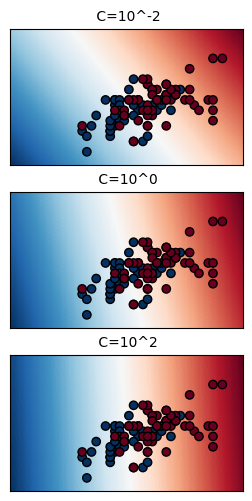

In [ ]:
C_2d_range = [1e-2, 1, 1e2]
classifiers = []
for C in C_2d_range:
    clf = LinearSVC(C=C)
    clf.fit(X_2d, y_2d)
    classifiers.append((C, clf))


plt.figure(figsize=(3, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, clf)) in enumerate(classifiers):
    # оценим функцию принятия решения в сетке
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # визуализируем функцию принятия решения для этих параметров
    plt.subplot(len(C_2d_range), 1, k + 1)
    plt.title(" C=10^%d" % (np.log10(C)), size="medium")

    # визуализируем влияние параметра на функцию принятия решения
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r, edgecolors="k")
    plt.xticks(())
    plt.yticks(())
    plt.axis("tight")

Во всех случаях видно, что разделяющая прямая — линейная.

# ЭТАП 3. SVM С ЯДРОМ RBF

SVM с ядром радиальной базисной функции можно вызвать, используя SVC из sklearn.svm.   
SVC — это SVM с ядром, тип которого указывается в параметрах при инициализации SVC.   
Но если не указывать никакого ядра, RBF идёт по умолчанию.
  
Поэтому нам достаточно вызвать clf = SVC(random_state=42).

Выполните настройку гиперпараметров с теми же параметрами (n_splits=5, test_size=0.2, random_state), но для параметров С, gamma и классификатора SVC

In [ ]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)

In [ ]:
list(C_range)

[0.01, 0.1, 1.0, 10.0]

In [ ]:
list(gamma_range)

[0.01, 0.1, 1.0, 10.0]

In [ ]:
param_grid = {
              'C':C_range,
              'gamma':gamma_range
              }

In [ ]:
model_svc = SVC(random_state=42)
# grid_search = GridSearchCV(model_svc, param_grid=param_grid, cv = kf, scoring='accuracy')
grid_search = GridSearchCV(model_svc, param_grid=param_grid, cv = kf)
model_grid = grid_search.fit(X,y)
print(model_grid.best_score_)
print(model_grid.best_params_)

0.9666666666666668
{'C': 1.0, 'gamma': 0.1}


In [ ]:
result = pd.DataFrame(model_grid.cv_results_)
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001918,0.000608,0.000731,0.000059,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",0.833333,0.866667,0.800000,0.900000,0.733333,0.826667,0.057349,13
1,0.002583,0.000241,0.001036,0.000222,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",0.866667,0.866667,0.833333,0.900000,0.766667,0.846667,0.045216,11
2,0.001581,0.000084,0.000761,0.000090,0.01,1.0,"{'C': 0.01, 'gamma': 1.0}",0.900000,0.933333,0.966667,0.933333,0.866667,0.920000,0.033993,7
3,0.001628,0.000073,0.000735,0.000100,0.01,10.0,"{'C': 0.01, 'gamma': 10.0}",0.633333,0.766667,0.766667,0.866667,0.800000,0.766667,0.076012,15
4,0.001515,0.000047,0.000677,0.000031,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.833333,0.866667,0.800000,0.900000,0.733333,0.826667,0.057349,13


Визуализируем результаты SVC для разных параметров

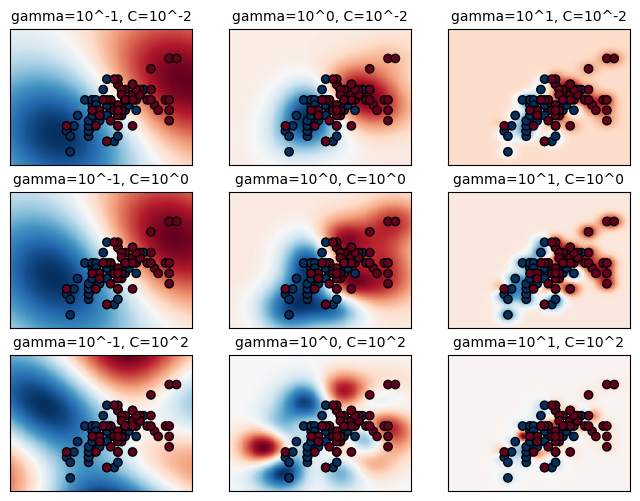

In [ ]:
C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

# Визуализация
# рисуем визуализацию эффектов параметров

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # оценим функцию принятия решения в сетке
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # визуализируем функцию принятия решения для этих параметров
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)), size="medium")

    # визуализируем влияние параметра на функцию принятия решения
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r, edgecolors="k")
    plt.xticks(())
    plt.yticks(())
    plt.axis("tight")

Решающая функция больше не является линейной и классы разделяются более точно.